<h2> Dataset Information </h2>

The Yelp_Polarity dataset contains 560000 entries, each consisting of the text of a business review from Yelp and a flat class label of 1 or 0 to indicate if the rating was positive or negative (1-2 stars was considered a negative review, while 3-4 was considered positive). It has been used many times for ML tasks, specifically text classification.

The class labels are:<br>
0 - negative<br>
1 - positive

The task performed on the dataset is binary sentiment classification -- the goal is to predict and output the label (positive or negative review) from the text of a review.

In [ ]:
!pip install contractions
!pip install nltk

# required imports/downloads

# pandas - for dataframes
import pandas as pd

# nltk - for pre-processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# contractions - for pre-processing
import contractions as contractions

# word2vec for learned representation
from gensim.models import Word2Vec

# numpy, kfold, accuracy scores for testing and evaluation
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# tensorflow for RNN
import tensorflow as tf
from tensorflow import keras

#   MLPClassifier for MLP
from sklearn.neural_network import MLPClassifier


from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM, GRU

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


<h2> Text Pre-Processing </h2>

In order to do any NLP tasks on the dataset, the data must first be prepared so that it is understandable by the machine. Textual data must be converted into a numerical vector.
Before the text is converted into a vector, it needs to be cleaned up. This will be done using methods from the Natural Language ToolKit (NLTK). The steps taken below are as follows:

* Expanding contractions
  This is done before tokenization as we are using NTLK's word_tokenise method, which splits the text into individual words and bits of punctuation. For example the sentence: "This isn't a pipe." would become ['This', 'is', "n't", 'a', 'pipe', '.'].
It is important to note that this method of tokenization splits up contracted words like "isn't". This ends up removing words like "not" when normalising, which can entirely flip the meaning of sentences. One solution to this is to expand all the contractions in the text first.
* Tokenisation
  The text will be split into an array of strings representing the terms present. As above, NTLK's word_tokenize method splits strings on whitespace and punctuation such as commas and full stops (which become individual tokens).
* Normalisation
  The text is standardised to remove punctuation and make all words lower case. One issue with this simple normalisation is that numbers are removed which may prove important for analysing Yelp reviews, however normalising numbers is tricky...
* Stop Word Removal
  Stop words are words that appear frequently but are not important in understanding a sentence. Removing these makes the text more unique which will help in making their recognition more unique. The NLTK comes in handy here again as it already has a list of stop words that can be removed.
* Stemming
  Returns words to their "root" form, by removing suffixes and prefixes. e.g. "university" -> "univers", "studying" -> "study".<br>
  Here the popular Snowball/Porter 2 stemmer is being used.

<h2> Representation Learning </h2>

Word2Vec will be used to create a vector representation of the text. Word2Vec is a moderately advanced method of creating a representation as it uses deep learning to "map" out words based on semantic meaning. Words with similar meaning should be close to each other in the map.

There are two methods for Word2Vec:
Continuous Bag Of Words - predicts the current word based on the surrounding words. The order of the words is unimportant.
Skip-Gram - predicts the context (surrounding words) based on the current word.

This coursework uses the CBOW method as it is well suited to large datasets, due to its focus on frequently used words. It is also faster than skip-gram as it maps the current word based on its context rather than the opposite way around.

In [ ]:
# Load the dataset
splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'test': 'plain_text/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/fancyzhx/yelp_polarity/" + splits["train"])

#print(df)

testdf = df.head(10000) # for now we will only take the first n reviews, to save some time while testing
#testdf = df

x = testdf.text # the text of the review
y = testdf.label # negative (0) or positive (1)

#print(x[0])
#print(y[0])

# preprocessing step
def preprocess(X):
  prep_text = []
  for x in X: #for each review text in the whole dataset
    x = contractions.fix(x) # expand all contractions
    token_text = word_tokenize(x) #tokenize the document
    normd_text = [token.lower() for token in token_text if token.isalpha()] #list compression to apply some simple cleaning (lower case casting and punctuation removal) to tokenized terms

    swr_text = [token for token in normd_text if token not in stopwords.words('english')] #list compression to remove any stopwords from our list

    stemmer = SnowballStemmer("english") #specify we are using the English stemming rules, as other languages are present in toolkit
    prep_text += [[stemmer.stem(word) for word in swr_text]] #list compression for applying the stemmer

  #prep_sentences = [" ".join(sentence) for sentence in prep_text] #we join the sentences back together to ensure compatibility with CountVec, which is doing some of it's own prep
  #print(prep_sentences)
  return prep_text

prep_x = preprocess(x)

# word2vec step
def word2vec_rep(sentence, w2v_model):
    embs = [w2v_model.wv[word] for word in sentence if word in w2v_model.wv.index_to_key]
    if len(embs) == 0:
        # Assign a default vector (e.g., zeros)
        return np.zeros(w2v_model.vector_size)
    return np.mean(np.array(embs), axis=0)

<h2> Algorithms </h2>

This coursework demonstrates 3 different algorithms:

kNN (k-Nearest Neighbours): A simple algorithm that classifies based on proximity to previous examples in the data. It learns by mapping the data points and their distance to each other.
To classify new data, the nearest x amount of data points are counted to determine which class the data will be put into – whichever class has the highest amount of data points in the radius of the new example will be its class. This is applicable for classification but may not be the best algorithm to use for text classification as it does not take into account the sequentiality of textual data.

MLP (Multi-Layer Perceptron): A type of Neural Network that uses a nonlinear activation function to identify and learn patterns in data. It has three layers: the input layer (which takes a numerical vector), the hidden layer(s) that uses weights and biases to transform the data, and the output layer that outputs a vector of probabilities for each class.
Weights and biased are learned and adjusted during training by processing data through the network, finding out the loss (the difference between the expected output and actual output), and backpropagating through the network — the error is run backwards through the network and the weights and biases are adjusted as it goes to solve the error. This process repeats until the loss is minimised.
MLP can be useful for text/sentiment classification as its nonlinear activation functions allow it to find the relationships between words (which are usually not linear).

RNN (Recurrent Neural Network): A type of Neural Network that has a higher level of interconnectivity through its layers. In an RNN, the output from a step is given back to the input of the next step. This functions as a kind of “memory” and is very useful in dealing with temporal or sequential data (like text), as it can take into account what came before in the sentence.
There are several types of RNN architectures. The one demonstrated in this coursework is many-to-one: it takes many inputs (words), and maps them to an output to predicts the sentiment to be positive or negative.

In [ ]:
# MLP
mlp_score = []

kf = StratifiedKFold(n_splits=5)

prepn_x = np.array(prep_x, dtype=object)

for train, test in kf.split(prepn_x,y):

  x_train, x_test, y_train, y_test = prepn_x[train], prepn_x[test], y[train], y[test]

  w2v_model = Word2Vec(vector_size=300, window=5, min_count=3, workers=4, sg=0)
  w2v_model.build_vocab(x_train, update=None)
  w2v_model.train(corpus_iterable=x_train, total_examples=len(x_train), epochs=10)

  x_train_representations = [word2vec_rep(instance, w2v_model) for instance in x_train]
  x_test_representations = [word2vec_rep(instance, w2v_model) for instance in x_test]

  #print("Length of y_train:", len(y_train))
  #print("Length of x_train_representations:", len(x_train_representations))
  #print("y_train unique values:", set(y_train))

  mlp = MLPClassifier(alpha=1, max_iter=10)
  mlp.fit(x_train_representations, y_train)
  mlp_predictions = mlp.predict(x_test_representations)
  mlp_acc = accuracy_score(mlp_predictions, y_test)
  mlp_score.append(mlp_acc)
  mlpf1 = f1_score(y_test, mlp_predictions, average='binary')

print("MLP Accuracy: ", np.mean(mlp_score))
print(mlpf1)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Accuracy:  0.8268000000000001
0.8254132231404959


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# KNN
knn_score = []

kf = StratifiedKFold(n_splits=5)
prepn_x = np.array(prep_x, dtype=object)

for train, test in kf.split(prepn_x,y):

  x_train, x_test, y_train, y_test = prepn_x[train], prepn_x[test], y[train], y[test]

  w2v_model = Word2Vec(vector_size=300, window=5, min_count=3, workers=4, sg=0)
  w2v_model.build_vocab(x_train, update=None)
  w2v_model.train(corpus_iterable=x_train, total_examples=len(x_train), epochs=10)

  x_train_representations = [word2vec_rep(instance, w2v_model) for instance in x_train]
  x_test_representations = [word2vec_rep(instance, w2v_model) for instance in x_test]

  kNN = KNeighborsClassifier(n_neighbors=3)
  kNN.fit(x_train_representations, y_train)
  knn_predictions = kNN.predict(x_test_representations)
  knn_acc = accuracy_score(knn_predictions, y_test)
  knn_score.append(knn_acc)
  knnf1 = f1_score(y_test, knn_predictions, average='binary')
print("kNN Accuracy:", np.mean(knn_score))
print(knnf1)

kNN Accuracy: 0.7646
0.7350993377483444


In [ ]:
# finding average and max length of entry in x for RNN padding
totalLength = 0
maxLength = 0
for row in range(x.shape[0]):
  l = len(x.loc[row])
  totalLength += l
  if l > maxLength:
    maxLength = l
    #print("New max length found at row " + str(row))

f = totalLength/x.shape[0]
print(maxLength)
print(f)

# average: 706
# max: 5042

5038
709.3576


In [ ]:
# RNN

# Tokenize and pad the sequences for RNN
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)  # Limit the vocabulary size to 10,000 words
tokenizer.fit_on_texts(prep_x)

# Convert texts to sequences
x_sequences = tokenizer.texts_to_sequences(prep_x)

# Pad the sequences to ensure equal length (RNN input requirement)
x_padded = pad_sequences(x_sequences, maxlen=800, padding='post', truncating='post')

# Prepare for training with stratified k-fold cross-validation
kf = StratifiedKFold(n_splits=5)
rnn_score = []

for train, test in kf.split(x_padded, y):
    x_train, x_test, y_train, y_test = x_padded[train], x_padded[test], y[train], y[test]

    # Build the RNN model
    RNN = Sequential()
    RNN.add(Embedding(input_dim=10000, output_dim=100, input_length=x_train.shape[1]))  # Embedding layer
    RNN.add(LSTM(64, return_sequences=False))  # LSTM layer
    RNN.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    RNN.fit(x_train, y_train, epochs=3, batch_size=32, verbose=0)

    # Evaluate the model
    #rnn_acc = RNN.evaluate(x_test, y_test, verbose=0)

    rnn_probabilities = RNN.predict(x_test)
    rnn_predictions = (rnn_probabilities > 0.5).astype(int)
    rnnf1 = f1_score(y_test, rnn_predictions, average='binary')

    rnn_acc = accuracy_score(y_test, rnn_predictions)
    rnn_score.append(rnn_acc)
# Print the average accuracy across all folds
print(f"RNN Accuracy: {np.mean(rnn_score)}")
print(rnnf1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step
RNN Accuracy: 0.5292999999999999
0.0


In [ ]:
print(rnn_score)

[0.5295, 0.5295, 0.5295, 0.529, 0.529]


In [ ]:
print(f"kNN Accuracy:", np.mean(knn_score), " MLP Accuracy:", np.mean(mlp_score), "RNN Accuracy:", np.mean(rnn_score))

kNN Accuracy: 0.7646  MLP Accuracy: 0.8268000000000001 RNN Accuracy: 0.5292999999999999


[Text(0, 0.5, '50%'),
 Text(0, 0.6, '60%'),
 Text(0, 0.7, '70%'),
 Text(0, 0.8, '80%'),
 Text(0, 0.9, '90%'),
 Text(0, 1.0, '100%')]

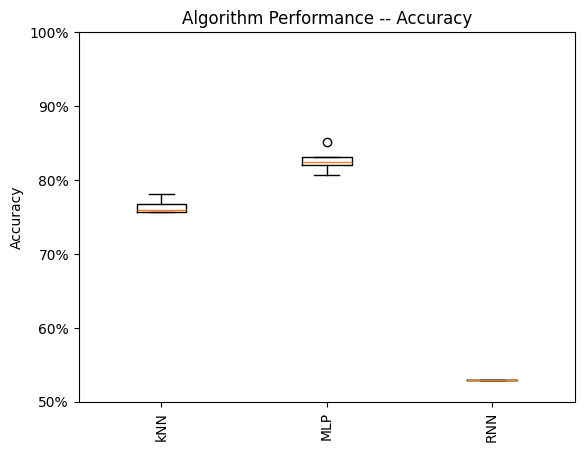

In [ ]:
# Evaluation

import matplotlib as plt
# plot accuracy
model_comp = []
model_comp.append(knn_score)
model_comp.append(mlp_score)
model_comp.append(rnn_score)

fig, ax2 = plt.pyplot.subplots()
ax2.set_title('Algorithm Performance -- Accuracy')
ax2.boxplot(model_comp)
ax2.set_xticklabels(['kNN', 'MLP', 'RNN'], rotation='vertical')

ax2.set_ylim(0.5, 1.0)  # Set y-axis limits
ax2.set_ylabel('Accuracy')  # Add label to y-axis
ax2.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])  # Set specific tick marks
ax2.set_yticklabels(['50%', '60%', '70%', '80%', '90%', '100%'])  # Custom tick labels

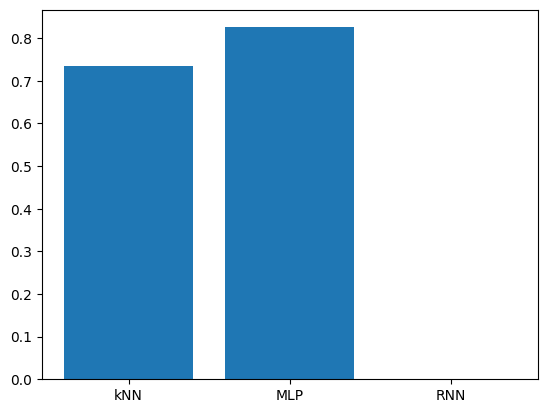

In [ ]:
#f1 scores
import matplotlib.pyplot as plt
import numpy as np

x = np.array(["kNN", "MLP", "RNN"])
y = np.array([knnf1, mlpf1, rnnf1])

plt.bar(x,y)
plt.show()

<h2> Evaluation </h2>

To evaluate the usefulness of the models and algorithms used, the accuracy score and F1 score were determined for each individual model. <br>
Accuracy: how many true positives and true negatives were found (accurate predictions), over the total predictions made.
A higher accuracy score means more correct predictions were made out of all predictions. This is useful to see the overall performance of the model, and gives a very general idea of how it is performing. However, accuracy score does not give much insight into false positives/negatives.

F1 score: the harmonic mean of precision and recall. Precision is how many predicted positive instances were actually positive, and recall is how many actual positive instances the model found.
A higher F1 score means that precision and recall are balanced in the model’s performance. This can be used to figure out if the model is over or underfitting, and is appropriate where both precision and recall are equally important.

MLP had the best (highest) accuracy and F1 scores, implying it is best suited to this task. kNN had moderately high accuracy and F1 scores. RNN surprisingly had very low scores, which could imply that either the algorithm is not best suited or the data has been prepared insufficiently. This could also be due to the method of padding being used as the input values have very widely differing lengths, or because of the relatively low amount of data used.
